In [52]:
import numpy
from matplotlib import pyplot
import monte_carlo

In [53]:
edges =  [((0,1),-1.0), ((1,2), -1.0), ((2,3), -1.0), ((3,4), -1.0)]
biases = [1.0, 0.0, 0.0, 0.0, 0.0]

## Test beta

In [54]:
betas = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

In [55]:
q_data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    print(beta)
    results = monte_carlo.run_quantum_monte_carlo_and_measure_spins(beta, 1000, 1000, edges, biases, (-1.0, 1.0))
    q_data[i] = numpy.mean(results, axis=0)

0.1
0.5
1.0
5.0
10.0
50.0
100.0


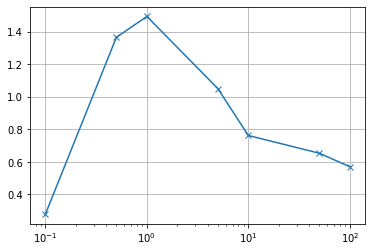

In [56]:
pyplot.plot(betas, q_data, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

In [57]:
data = numpy.zeros(len(betas))
for i, beta in enumerate(betas):
    results = monte_carlo.run_monte_carlo(beta, 1000, 1000, edges, biases)
    results = numpy.asarray([state for _, state in results])
    results = numpy.sum((results * 2) - 1, axis=-1)
    data[i] = numpy.mean(results, axis=0)

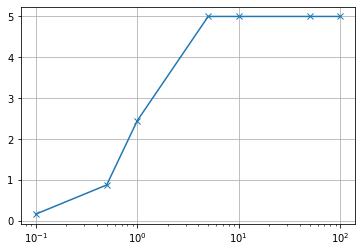

In [58]:
pyplot.plot(betas, data, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

## Test convergence

In [59]:
timesteps = [10, 50, 100, 500, 1000, 5000, 10000]
beta = 1.0

In [60]:
q_data_conv = numpy.zeros(len(timesteps))
for i, ts in enumerate(timesteps):
    results = monte_carlo.run_quantum_monte_carlo_and_measure_spins(beta, ts, 1000, edges, biases, (-1.0, 1.0))
    q_data[i] = numpy.mean(results, axis=0)

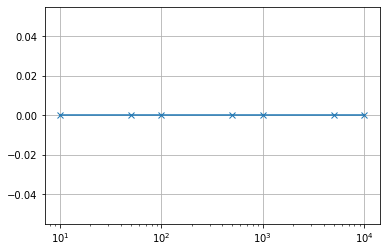

In [61]:
pyplot.plot(timesteps, q_data_conv, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

In [62]:
data_conv = numpy.zeros(len(timesteps))
for i, beta in enumerate(timesteps):
    results = monte_carlo.run_monte_carlo(beta, ts, 1000, edges, biases)
    results = numpy.asarray([state for _, state in results])
    results = numpy.sum((results * 2) - 1, axis=-1)
    data[i] = numpy.mean(results, axis=0)

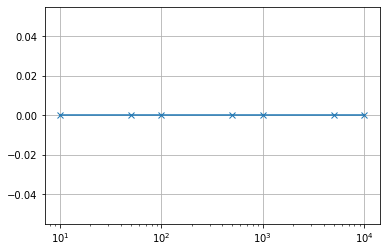

In [63]:
pyplot.plot(timesteps, data_conv, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

## Exact Diagonalization

In [64]:
import scipy.linalg

In [65]:
ham = numpy.zeros((2**len(biases), 2**len(biases)))
for i in range(2**len(biases)):
    state = [(i >> j) & 1 for j in range(len(biases))]
    h = 0.0
    for s, b in zip(state, biases):
        if s:
            h -= b
    for (vara, varb), j in edges:
        if state[vara] == state[varb]:
            h += j
        else:
            h -= j
    ham[i,i] = h

spin_diag = []
for i in range(2**len(biases)):
    state = [(i >> j) & 1 for j in range(len(biases))]
    spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1))
spin_op = numpy.diag(spin_diag)

In [66]:
ed_data = []
for beta in betas:
    expm = scipy.linalg.expm(-beta*ham)
    ed_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))

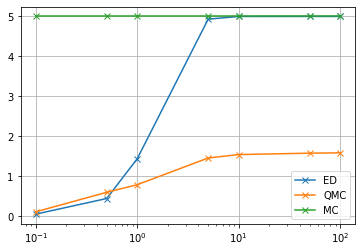

In [67]:
pyplot.plot(betas, ed_data, 'x-', label="ED")
pyplot.plot(betas, q_data, 'x-', label="QMC")
pyplot.plot(betas, data, 'x-', label="MC")
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.show()